In [32]:
import pandas as pd
import numpy as np 
from rdkit import Chem 
from rdkit import DataStructs 
from rdkit.Chem import AllChem 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
import umap
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import silhouette_score 
import math
import matplotlib.patches as patches

In [33]:
warnings.filterwarnings("ignore")

In [34]:
#reads the csv file to a pd data frame (df) 
df = pd.read_csv("/Users/schwegler2/Downloads/es9b04833_si_004.csv")

In [35]:
#Create a FingerprintGenerator object 
fpgen = AllChem.GetRDKitFPGenerator()

#create a list of SMILES (simplified molecular-input line entry system) strings from the df data frame 
smiles_list=df["smiles"].values.tolist()

#Construct a rdkit.Chem.rdchem.Mol object from each SMILES string
mol_list=[Chem.MolFromSmiles(x) for x in smiles_list]

#convert rdkit.Chem.rdchem.Mol objects to fingerprint bit vectors
fps = [fpgen.GetFingerprint(x) for x in mol_list]

In [36]:
#create a list of np arrays of Morgan Fingerprints for each molecule
fp = []
for i in range(len(mol_list)):
    fp.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol_list[i], radius=2, nBits=1024)))

In [37]:
#set the column 'fingerprint' to the array fp 
df["fingerprint"]= fp

In [38]:
#Pull all of the relevant columns from the dataframe
column_names = [col for col in df.columns if col not in ["smiles", "fingerprint"]]

#set X to the column 'fingerprint' (input) 
X = df["fingerprint"].copy()

#set Y to the columns in column names (output) 
Y = df[column_names].copy()

#Convert X from a pandas series to a np array 
fp_list = [np.array(fp) for fp in X]
X = np.vstack(fp_list)


Y_np = df[column_names].to_numpy()

In [39]:
#Principal Component Analysis: dimensionality reduction method 
#Reduce the number of varuables of a data set, while preserving as much information as possible 
pca = PCA(n_components = 2)

#[0, 1, 0, ..., 1] -> [0.543, 0.867] 
X_dimension_reduced = pca.fit_transform(X)

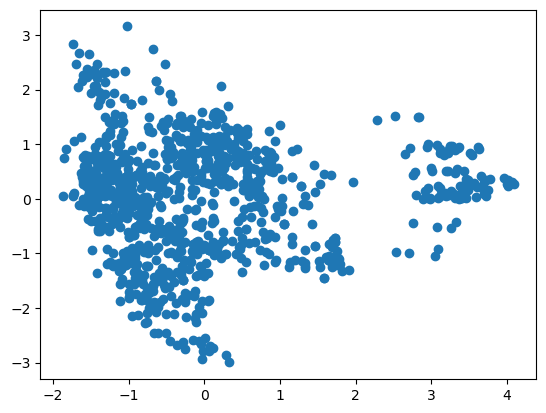

In [40]:
#Plot the dimension reduced data 
plt.scatter(X_dimension_reduced[:,0],X_dimension_reduced[:,1])

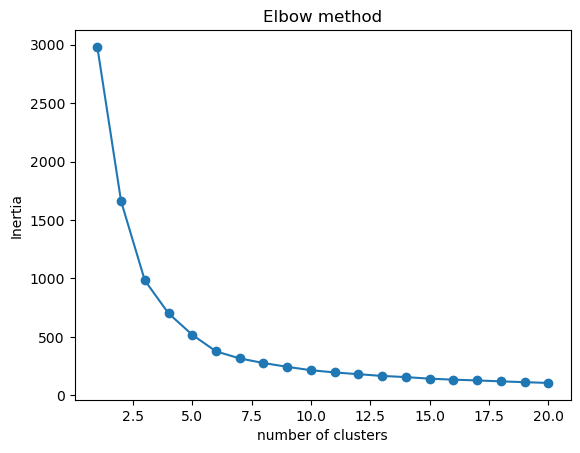

In [41]:
#Intertia measures how well a data set was clustered  
#A good model is one with a lot inertia and number of clusters 
#Find the optimal number of clusters by plotting the inertias and using the elbow method 
inertias = []

for i in range (1,21):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_dimension_reduced)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,21), inertias, marker = 'o')
plt.title("Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

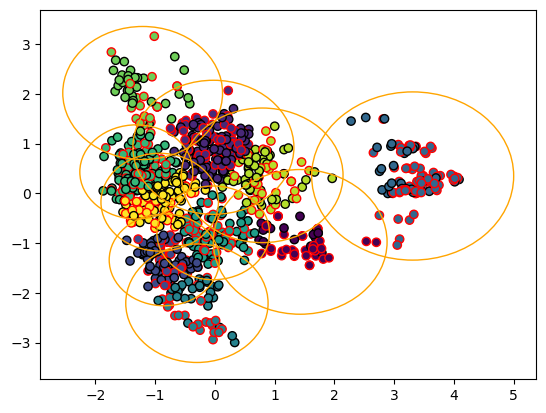

In [42]:
#using the elbow method, 10 clusters is utilized 
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_dimension_reduced)

#Outline data points that are bioactive with red 
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')

centers = kmeans.cluster_centers_
radius = []
for i in range (0,10):
    max = 0
    for l in range (0, len(kmeans.labels_)):
        if kmeans.labels_[l]  == i:
            new = math.dist(centers[i], X_dimension_reduced[l])
            if new > max:
                max = new 
    radius.append(max)
    
#Plot the data colored with their clusters 
#plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_)
plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_, edgecolors=color_array)

#circle each cluster 
for i in range(10):
    circle = patches.Circle(centers[i], radius[i]+.18, fill=False, edgecolor='orange')
    plt.gca().add_patch(circle)
plt.show()

In [43]:
silhouette_score(X_dimension_reduced, kmeans.fit_predict(X_dimension_reduced))

0.4186607124135742

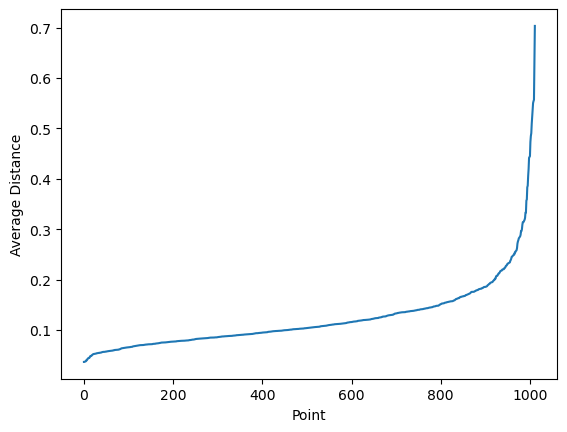

In [44]:
##DBSCAN##
k = 10 
nbrs = NearestNeighbors(n_neighbors=k).fit(X_dimension_reduced)
distances, indices = nbrs.kneighbors(X_dimension_reduced)
 
avg_distances = distances.mean(axis=1)
 
plt.plot(sorted(avg_distances))
plt.xlabel('Point')
plt.ylabel('Average Distance')
plt.show()

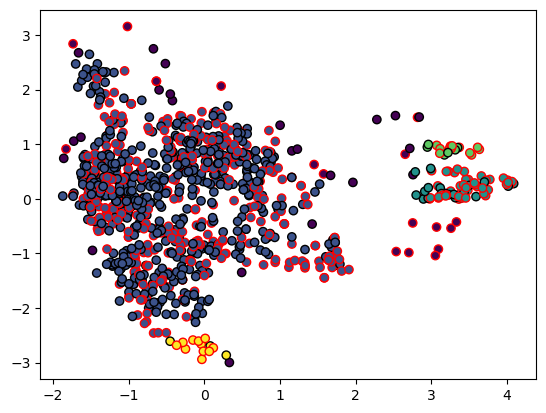

In [45]:
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')


clustering = DBSCAN(eps=0.23, min_samples=5).fit(X_dimension_reduced)


plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=clustering.labels_, edgecolors=color_array)
plt.show()

In [46]:
silhouette_score(X_dimension_reduced, clustering.fit_predict(X_dimension_reduced))

0.24562388713024277

In [47]:
#t-distributed stochastic neighbor embedding 
#models each high dimensional object in such a way that similar objects are modeled by near by points 
#and dissimilar points are modeled by distant poitnts 
tsne = TSNE(n_components=2) 
X_dimension_reduced = tsne.fit_transform(X)

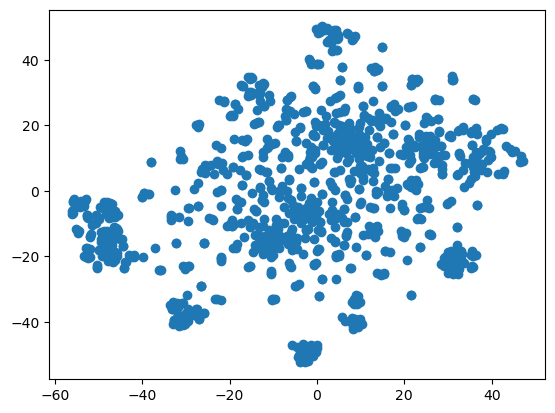

In [48]:
plt.scatter(X_dimension_reduced[:,0],X_dimension_reduced[:,1])

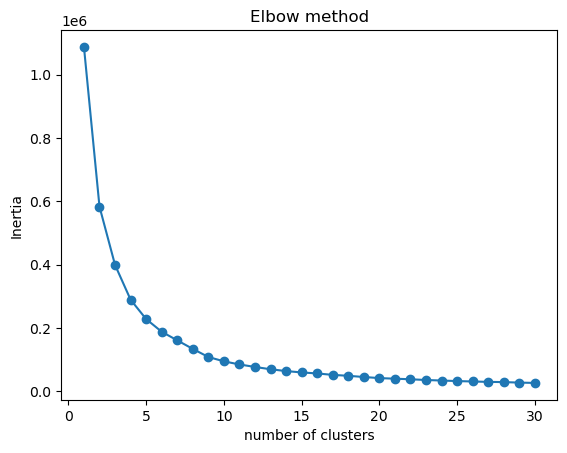

In [49]:
inertias = []

for i in range (1,31):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_dimension_reduced)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,31), inertias, marker = 'o')
plt.title("Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

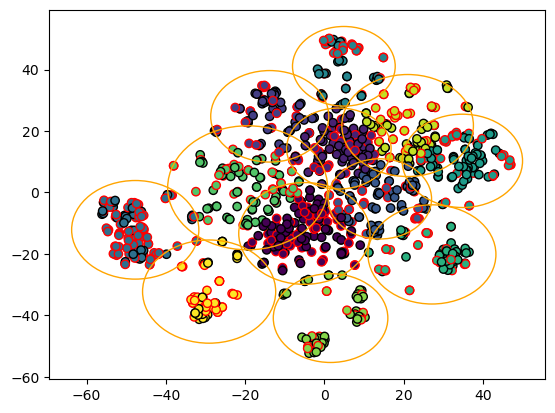

In [50]:
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')

kmeans = KMeans(n_clusters=12)
kmeans.fit(X_dimension_reduced)

centers = kmeans.cluster_centers_
radius = []
for i in range (0,12):
    max = 0
    for l in range (0, len(kmeans.labels_)):
        if kmeans.labels_[l]  == i:
            new = math.dist(centers[i], X_dimension_reduced[l])
            if new > max:
                max = new 
    radius.append(max)
    
#Plot the data colored with their clusters 
#plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_)
plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_, edgecolors=color_array)
for i in range(12):
    circle = patches.Circle(centers[i], radius[i]+.18, fill=False, edgecolor='orange')
    plt.gca().add_patch(circle)

plt.show()

In [51]:
silhouette_score(X_dimension_reduced, kmeans.fit_predict(X_dimension_reduced))

0.42605332

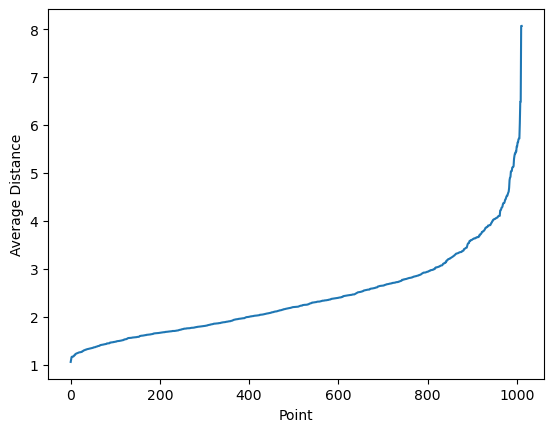

In [52]:
##DBSCAN##
k = 10 
nbrs = NearestNeighbors(n_neighbors=k).fit(X_dimension_reduced)
distances, indices = nbrs.kneighbors(X_dimension_reduced)
 
avg_distances = distances.mean(axis=1)
 
plt.plot(sorted(avg_distances))
plt.xlabel('Point')
plt.ylabel('Average Distance')
plt.show()

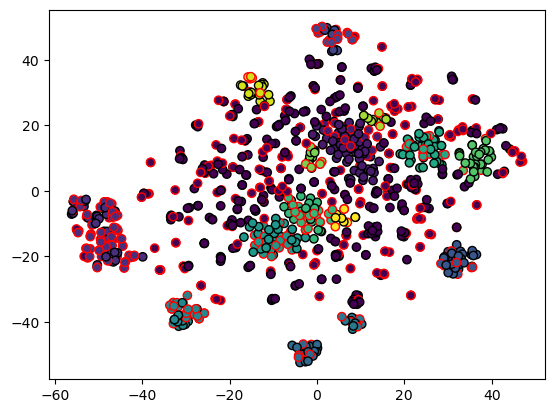

In [53]:
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')



clustering = DBSCAN(eps=3.5, min_samples=13).fit(X_dimension_reduced)


    
#Plot the data colored with their clusters 
#plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_)
plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=clustering.labels_, edgecolors=color_array)

plt.show()

In [54]:
silhouette_score(X_dimension_reduced, clustering.fit_predict(X_dimension_reduced))

0.003830559

In [55]:
#Uniform Manifold Approximation and Projection
#Similar to t-SNE but ensured that local structure is preserved in balance with global structure 
umap = umap.UMAP(n_components=2)
X_dimension_reduced = umap.fit_transform(X)

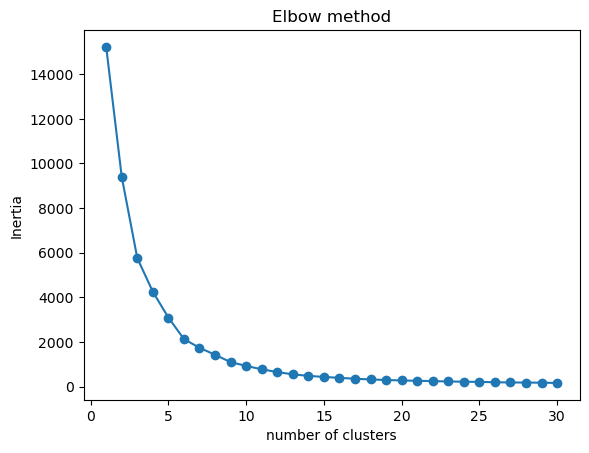

In [56]:
inertias = []

for i in range (1,31):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_dimension_reduced)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,31), inertias, marker = 'o')
plt.title("Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

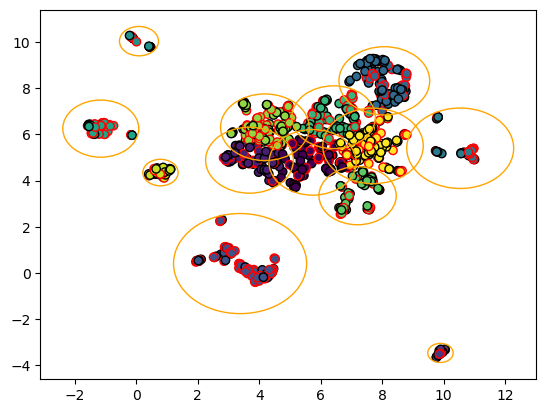

In [57]:
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')



kmeans = KMeans(n_clusters=13)
kmeans.fit(X_dimension_reduced)

centers = kmeans.cluster_centers_
radius = []
for i in range (0,13):
    max = 0
    for l in range (0, len(kmeans.labels_)):
        if kmeans.labels_[l]  == i:
            new = math.dist(centers[i], X_dimension_reduced[l])
            if new > max:
                max = new 
    radius.append(max)
    
#Plot the data colored with their clusters 
#plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_)
plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_, edgecolors=color_array)
for i in range(13):
    circle = patches.Circle(centers[i], radius[i]+.18, fill=False, edgecolor='orange')
    plt.gca().add_patch(circle)

plt.show()

In [58]:
silhouette_score(X_dimension_reduced, kmeans.fit_predict(X_dimension_reduced))

0.5437458

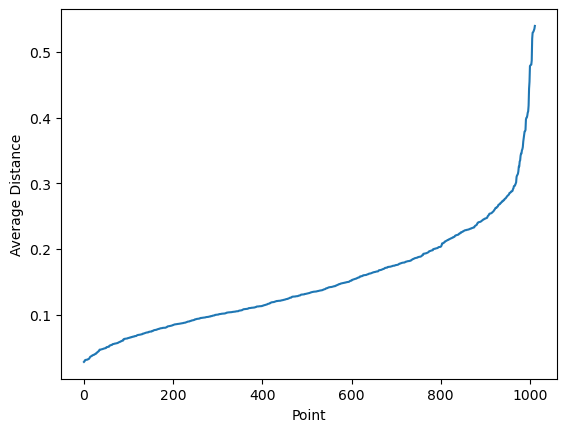

In [59]:
##DBSCAN##
k = 10 
nbrs = NearestNeighbors(n_neighbors=k).fit(X_dimension_reduced)
distances, indices = nbrs.kneighbors(X_dimension_reduced)
 
avg_distances = distances.mean(axis=1)
 
plt.plot(sorted(avg_distances))
plt.xlabel('Point')
plt.ylabel('Average Distance')
plt.show()

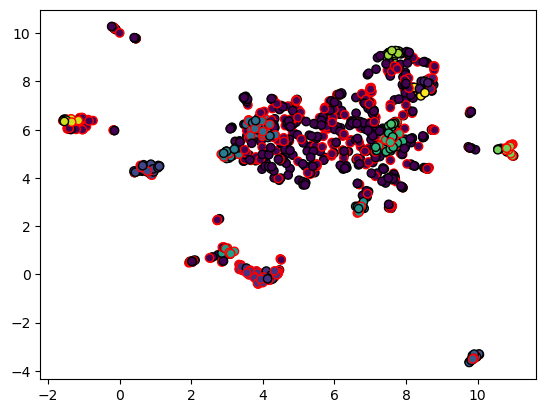

In [60]:
color_array=[]

for i in range (0,len(Y_np)):
    l = 0
    for j in range (0, 26):
        if Y_np[i][j] == 1:
            l += 1
    if l > 0:
        color_array.append('red')
    else:
        color_array.append('black')

clustering = DBSCAN(eps=0.23, min_samples=15).fit(X_dimension_reduced)

    
#Plot the data colored with their clusters 
#plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=kmeans.labels_)
plt.scatter(X_dimension_reduced[:,0], X_dimension_reduced[:,1], c=clustering.labels_, edgecolors=color_array)

plt.show()

In [61]:
silhouette_score(X_dimension_reduced, clustering.fit_predict(X_dimension_reduced))

-0.0931261